In [1]:
# importação das bibliotecas necessárias para o carregamento e tratamento dos dados

import matplotlib.pyplot as plt
from PIL import Image,ImageOps, ImageFilter
import numpy as np
from sklearn.feature_extraction import image
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
import imagecodecs
import tifffile as tiff 
import skimage
import random
from skimage.io import imshow
import cv2

# DATASET

In [2]:
# carregando a imagem geotiff

img_dataset = tiff.imread('SONAR_CLIP.tif')

In [3]:
# informações da imagem

print(type(img_dataset))
print(img_dataset.shape)

<class 'numpy.ndarray'>
(5854, 4288, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x14d25011220>)

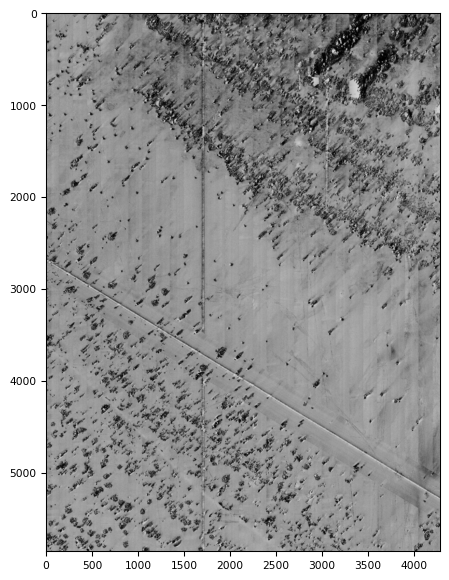

In [4]:
# visualizando a imagem

tiff.imshow(img_dataset)

In [4]:
# necessário cortar a imagem pois com o tamanho da imagem original não houve memória RAM suficiente para fazer os patches.

img_dataset_clip = img_dataset[4500:4800,2000:2300]

In [5]:
# informações da imagem recortada

print(type(img_dataset_clip))
print(img_dataset_clip.shape)

<class 'numpy.ndarray'>
(300, 300, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x14d24fe2940>)

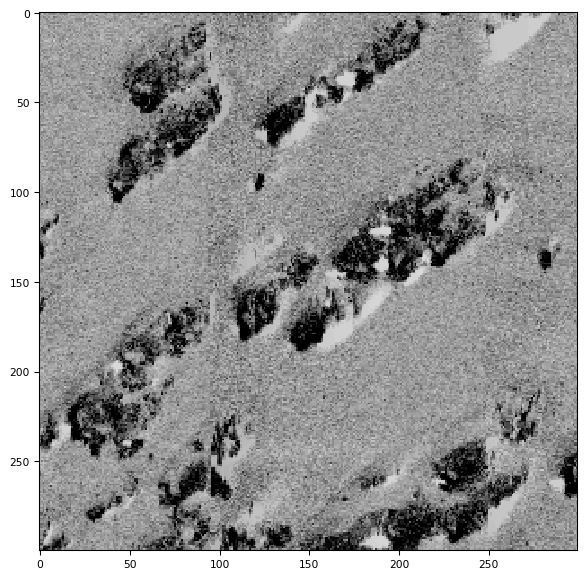

In [7]:
# visualizando a imagem recortada

tiff.imshow(img_dataset_clip)

In [6]:
# transformando a imagem geotiff em patchs
# utilizado patchs de tamanho 128 x 128 pixels

patches_dataset = image.extract_patches_2d(img_dataset_clip,(128,128),max_patches=0.2,random_state=42)

In [7]:
# quantidade de imagens do dataset

print(len(patches_dataset))

5985


In [8]:
# quantidade de pixels de cada imagem

print(np.prod(patches_dataset.shape[1:]))

49152


In [9]:
print('patches_dataset shape: {}'.format(patches_dataset.shape))

patches_dataset shape: (5985, 128, 128, 3)


In [10]:
# renomeando a variável para um nome menor

dataset = patches_dataset
dataset.shape

(5985, 128, 128, 3)

# TARGET

In [11]:
# carregando a imagem geotiff

img_target = tiff.imread('alvo_reflet_lama_rgb.tif')

In [12]:
# informações da imagem

print(type(img_target))
print(img_target.shape)

<class 'numpy.ndarray'>
(5854, 4288, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x14d24f53a90>)

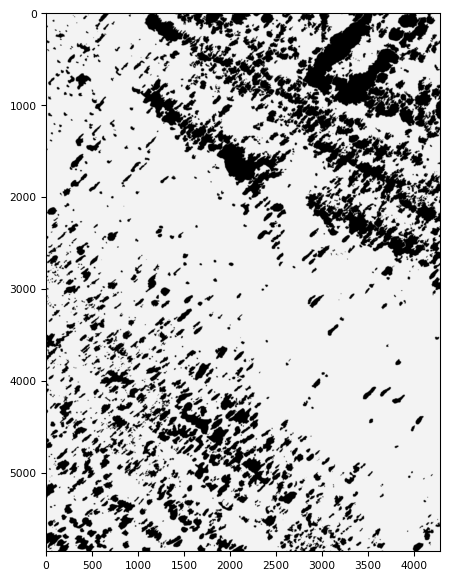

In [15]:
# visualizando a imagem

tiff.imshow(img_target)

In [13]:
# necessário cortar a imagem do target para as mesmas dimensões da imagem do dataset.

img_target_clip = img_target[4500:4800,2000:2300]

In [14]:
# informações da imagem recortada

print(type(img_target_clip))
print(img_target_clip.shape)

<class 'numpy.ndarray'>
(300, 300, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x14d2505b280>)

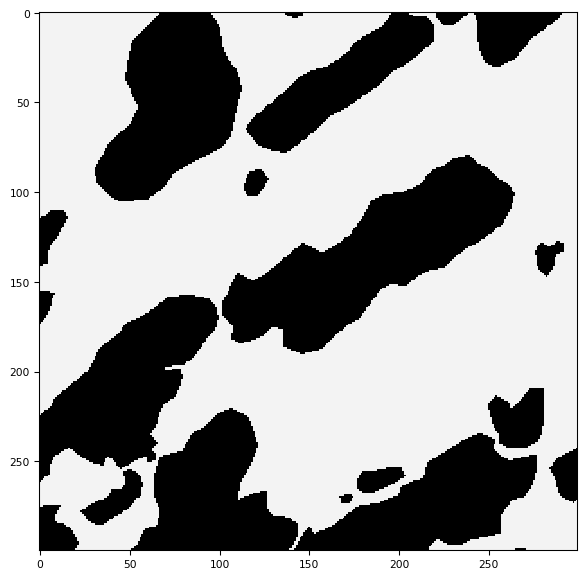

In [18]:
# visualizando a imagem recortada

tiff.imshow(img_target_clip)

In [15]:
# 2 targets => alvo refletivo com pixel=0 e fundo lamoso com pixel=243 

np.unique(img_target_clip)

array([  0, 243], dtype=uint8)

In [18]:
img_target_clip.shape

(300, 300, 3)

In [16]:
# transformando o target para escala de cinza para retirar a 3 dimensão (=3)

img_target_clip_gray = cv2.cvtColor(img_target_clip, cv2.COLOR_BGR2GRAY)

In [17]:
# shape do target sem a 3 dimensão

img_target_clip_gray.shape

(300, 300)

In [25]:
# inserindo a 3 dimensão (=1). Isso foi necessário para o target ter dimensão = 1 
# para poder utilizar o loss = binary_crossentropy no modelo.

img_target_clip_gray_3D = np.expand_dims(img_target_clip_gray, axis = 2)
img_target_clip_gray_3D.shape

(300, 300, 1)

In [26]:
# continuamos com 2 targets => alvo refletivo com pixel=0 e fundo lamoso com pixel=243 

np.unique(img_target_clip_gray_3D)

array([  0, 243], dtype=uint8)

In [27]:
# transformando a imagem geotiff em patchs
# utilizado patches de tamanho 128 x 128 pixels, iguais ao do dataset

patches_img_target_clip_gray_3D = image.extract_patches_2d(img_target_clip_gray_3D,(128,128),max_patches=0.2,random_state=42)

In [28]:
# quantidade de imagens do target

print(len(patches_img_target_clip_gray_3D))

5985


In [29]:
# quantidade de pixels de cada imagem

print(np.prod(patches_img_target_clip_gray_3D.shape[1:]))

16384


In [30]:
print('patches_img_target_clip_gray_3D shape: {}'.format(patches_img_target_clip_gray_3D.shape))

patches_img_target_clip_gray_3D shape: (5985, 128, 128)


In [31]:
# inserido 4 dimensão (=1) e renomeando a variável do target

target = np.expand_dims(patches_img_target_clip_gray_3D, axis = 3)

In [32]:
target.shape

(5985, 128, 128, 1)

# VISUALIZAÇÃO DO DATASET E TARGET

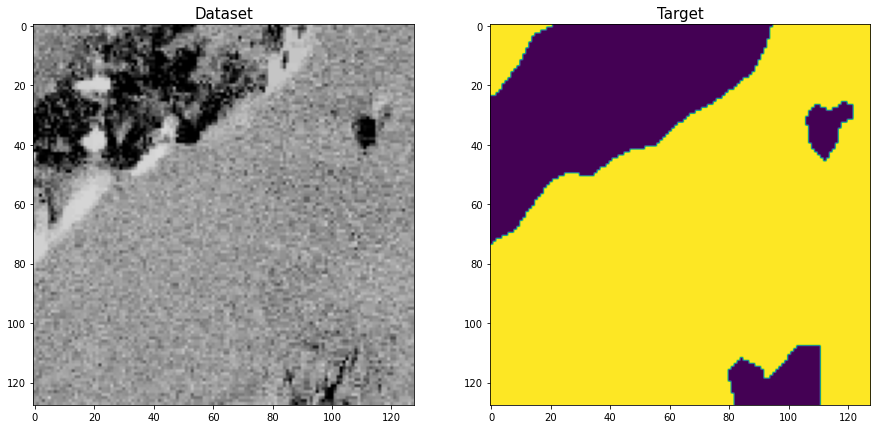

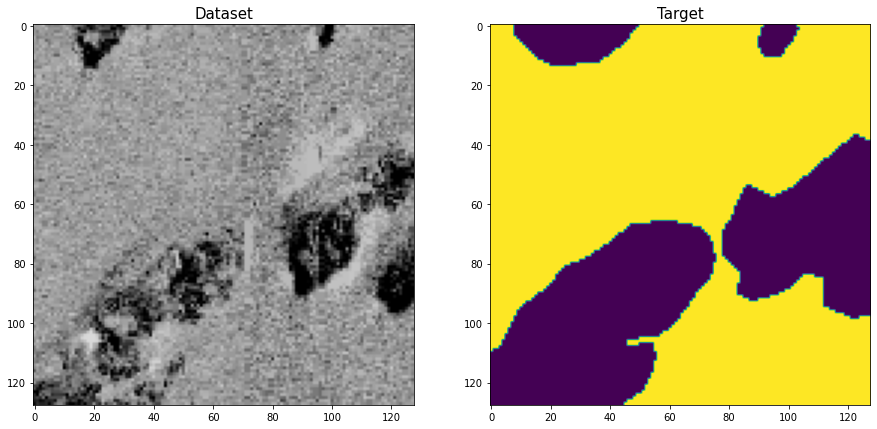

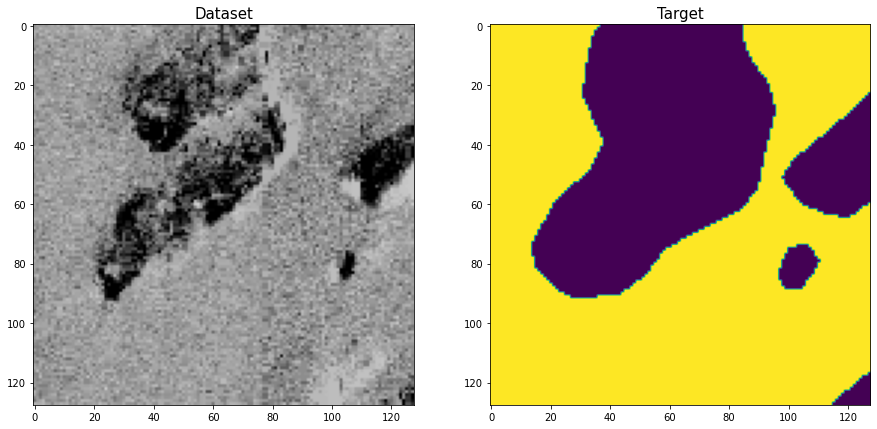

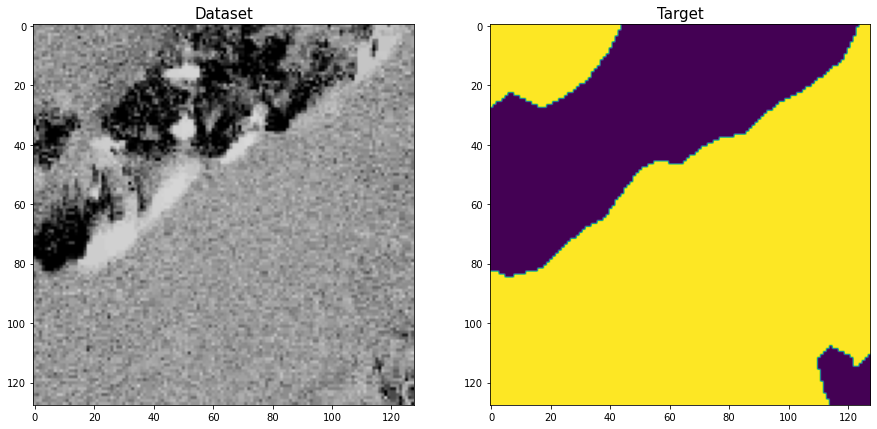

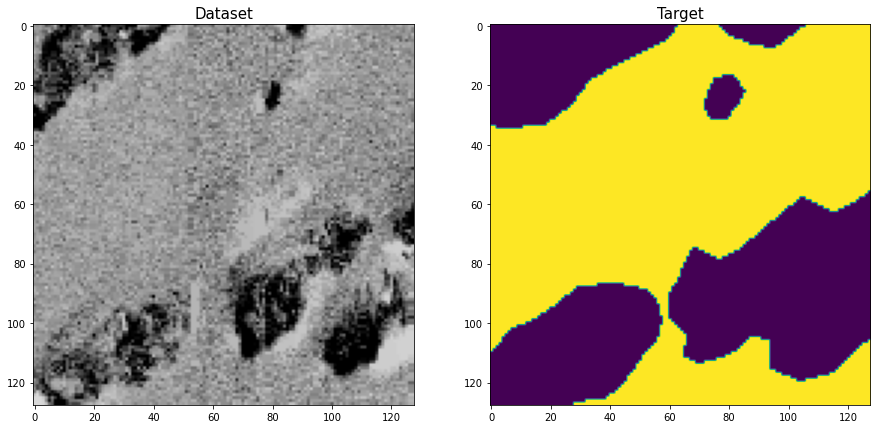

In [33]:
for i in range(5):
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.title("Dataset",fontsize=15)
        plt.imshow(dataset[i])
        plt.subplot(1,2,2)
        plt.title("Target",fontsize=15)
        plt.imshow(target[i])
        plt.show()

# MODELOS U-NET

In [34]:
# importação das bibliotecas necessárias para modelagem

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.layers import Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,Flatten ,Dense ,Concatenate ,UpSampling2D,Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras.layers import Activation
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import load_model

In [35]:
# divisão do dataset e target em dados de treinamento (80%) e dados de teste (20%).

x_train, x_test, y_train, y_test = train_test_split(dataset, target, test_size=0.20, random_state=42)

In [36]:
# separar 3000 amostras para validação

x_val = x_train[-1200:]
y_val = y_train[-1200:]
x_train = x_train[:-1200]
y_train = y_train[:-1200]

In [37]:
# verificando o shape dos dados de treinamento, teste e validação

print('Shape do x_train : {}'.format(x_train.shape))
print('Shape do x_test : {}'.format(x_test.shape))
print('Shape do y_train : {}'.format(y_train.shape))
print('Shape do y_test : {}'.format(y_test.shape))
print('Shape do x_val : {}'.format(x_val.shape))
print('Shape do y_val : {}'.format(y_val.shape))

Shape do x_train : (3588, 128, 128, 3)
Shape do x_test : (1197, 128, 128, 3)
Shape do y_train : (3588, 128, 128, 1)
Shape do y_test : (1197, 128, 128, 1)
Shape do x_val : (1200, 128, 128, 3)
Shape do y_val : (1200, 128, 128, 1)


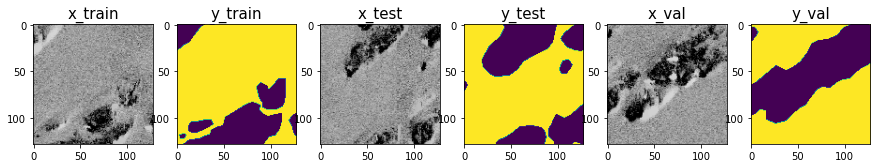

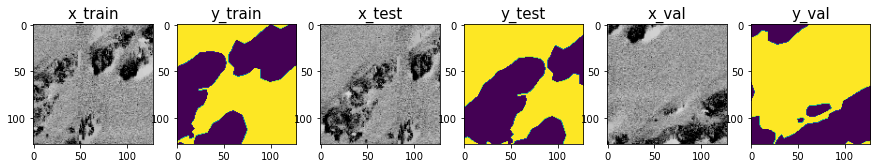

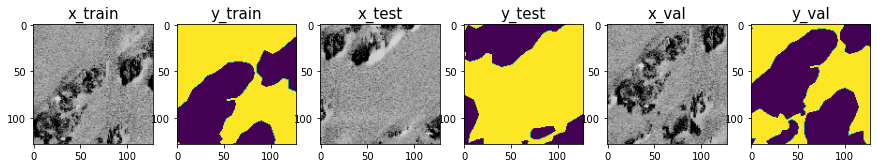

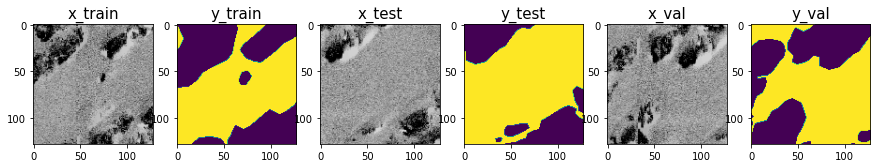

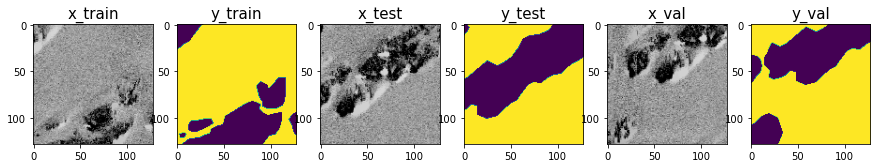

In [38]:
# visualização dos dados de treinamento, teste e validação

for i in range(5):
        plt.figure(figsize=(15,15))
        plt.subplot(1,6,1)
        plt.title("x_train",fontsize=15)
        plt.imshow(x_train[i])
        plt.subplot(1,6,2)
        plt.title("y_train",fontsize=15)
        plt.imshow(y_train[i])
        plt.subplot(1,6,3)
        plt.title("x_test",fontsize=15)
        plt.imshow(x_test[i])
        plt.subplot(1,6,4)
        plt.title("y_test",fontsize=15)
        plt.imshow(y_test[i])
        plt.subplot(1,6,5)
        plt.title("x_val",fontsize=15)
        plt.imshow(x_val[i])
        plt.subplot(1,6,6)
        plt.title("y_val",fontsize=15)
        plt.imshow(y_val[i])       
        plt.show() 

In [39]:
# transformação em float e normalização dos dados de entrada

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

In [43]:
# normalização dados de saída para utilizar o loss = binary_crossentropy no modelo

y_train = y_train.astype('float32') / 243
y_test = y_test.astype('float32') / 243
y_val = y_val.astype('float32') / 243

# Modelo U-Net 1

In [53]:
# Construção do modelo

inputs=tf.keras.layers.Input(shape=(128,128,3))

# Contração

c1=Conv2D(16, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(inputs)
c1=Conv2D(16, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(c1) 
p1=MaxPooling2D((2,2),strides=2)(c1)

c2=Conv2D(32, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(p1)
c2=Conv2D(32, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c2)
p2=MaxPooling2D((2,2),strides=2)(c2)

c3=Conv2D(64, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(p2)
c3=Conv2D(64, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c3)
p3=MaxPooling2D((2,2),strides=2)(c3)

c4=Conv2D(128, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(p3)
c4=Conv2D(128, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c4)
p4=MaxPooling2D((2,2),strides=2)(c4)

c5=Conv2D(256, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(p4)
c5=Conv2D(256, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c5)

# Expansão

U6=Conv2DTranspose(128, kernel_size=(2,2),activation="relu", kernel_initializer='he_normal',padding="same",strides=(2,2))(c5)
U6=Concatenate()([U6, c4])
c6=Conv2D(128, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(U6)
c6=Conv2D(128, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c6)


U7=Conv2DTranspose(64, kernel_size=(2,2),activation="relu", kernel_initializer='he_normal',padding="same",strides=(2,2))(c6)
U7=Concatenate()([U7, c3])
c7=Conv2D(64, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(U7)
c7=Conv2D(64, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c7)


U8=Conv2DTranspose(32, kernel_size=(2,2),activation="relu", kernel_initializer='he_normal',padding="same",strides=(2,2))(c7)
U8=Concatenate()([U8, c2])
c8=Conv2D(32, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(U8)
c8=Conv2D(32, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c8)


U9=Conv2DTranspose(16, kernel_size=(2,2),activation="relu", kernel_initializer='he_normal',padding="same",strides=(2,2))(c8)
U9=Concatenate()([U9, c1])
c9=Conv2D(16, kernel_size=(3,3),padding="same", kernel_initializer='he_normal',activation="relu")(U9)
c9=Conv2D(16, kernel_size=(3,3),activation="relu", kernel_initializer='he_normal',padding="same")(c9)


output=Conv2D(1, kernel_size=(1,1),activation="sigmoid")(c9)

modelo_1=tf.keras.Model(inputs=[inputs],outputs=[output])

In [54]:
# compilação do modelo

loss=tf.keras.losses.BinaryCrossentropy()

modelo_1.compile(optimizer="adam",loss=loss,metrics=["accuracy"])

modelo_1.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_39[0][0]                  
_______________________________________________________________________________________

In [55]:
# checkpoint

checkpoint=tf.keras.callbacks.ModelCheckpoint("model-SONAR-REV=H.h5", verbose=1, save_best_only=True)

# callbacks

Callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),checkpoint]


# treinamento do modelo 

Results_1=modelo_1.fit(x_train,y_train, validation_data = (x_val,y_val), batch_size=16, epochs=10, callbacks=Callbacks)

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9525
Epoch 00001: val_loss improved from inf to 0.04979, saving model to model-SONAR-REV=H.h5
225/225 [==============================] - 303s 1s/step - loss: 0.1064 - accuracy: 0.9525 - val_loss: 0.0498 - val_accuracy: 0.9797
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9903
Epoch 00002: val_loss improved from 0.04979 to 0.01769, saving model to model-SONAR-REV=H.h5
225/225 [==============================] - 274s 1s/step - loss: 0.0229 - accuracy: 0.9903 - val_loss: 0.0177 - val_accuracy: 0.9926
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9939
Epoch 00003: val_loss improved from 0.01769 to 0.01125, saving model to model-SONAR-REV=H.h5
225/225 [==============================] - 263s 1s/step - loss: 0.0146 - accuracy: 0.9939 - val_loss: 0.0112 - val_accuracy: 0.9954
Epoch 4/10
225/225 [=====================

In [56]:
# melhores acurácias e loss dos dados de treinamento e validação

print('melhor acurácia treino:', np.max(Results_1.history["accuracy"]))
print('melhor acurácia validação:', np.max(Results_1.history["val_accuracy"]))
print('melhor loss treino:', np.min(Results_1.history["loss"]))
print('melhor loss validação:', np.min(Results_1.history["val_loss"]))

melhor acurácia treino: 0.9980640411376953
melhor acurácia validação: 0.9978954195976257
melhor loss treino: 0.004801551345735788
melhor loss validação: 0.005209874827414751


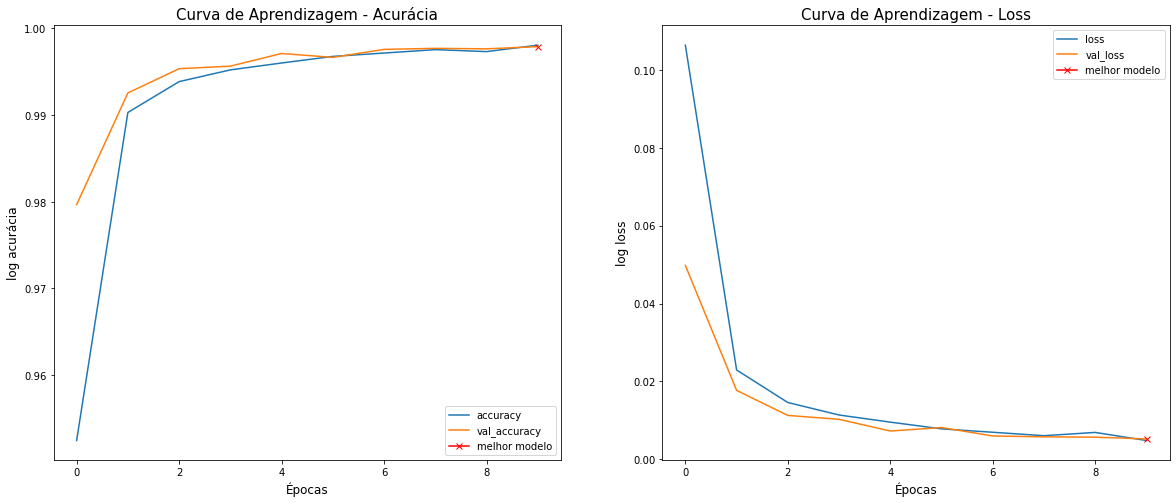

In [57]:
# performance do modelo graficamente

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title("Curva de Aprendizagem - Acurácia", fontsize=15)
plt.plot(Results_1.history["accuracy"], label="accuracy")
plt.plot(Results_1.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(Results_1.history["val_accuracy"]), np.max(Results_1.history["val_accuracy"]), marker="x", color="r", label="melhor modelo")
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("log acurácia",fontsize=12)
plt.legend()
plt.subplot(1,2,2)
plt.title("Curva de Aprendizagem - Loss", fontsize=15)
plt.plot(Results_1.history["loss"], label="loss")
plt.plot(Results_1.history["val_loss"], label="val_loss")
plt.plot( np.argmin(Results_1.history["val_loss"]), np.min(Results_1.history["val_loss"]), marker="x", color="r", label="melhor modelo")
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("log loss",fontsize=12)
plt.legend()

In [58]:
# carregamento do melhor modelo

modelo_1.load_weights("model-SONAR-REV=H.h5")

In [59]:
# avaliação da acurácia e loss nos dados de teste

test_loss, test_acc = modelo_1.evaluate(x_test,  y_test, verbose=2)

print('\nAcurácia dos dados de teste:', test_acc)

38/38 - 18s - loss: 0.0051 - accuracy: 0.9979

Acurácia dos dados de teste: 0.9979339838027954


In [60]:
# previsões

previsao_1 = modelo_1.predict(x_test)

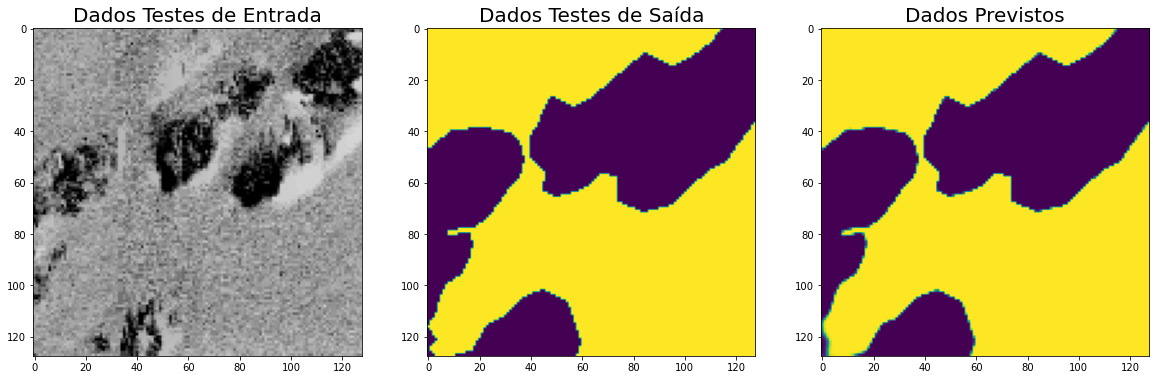

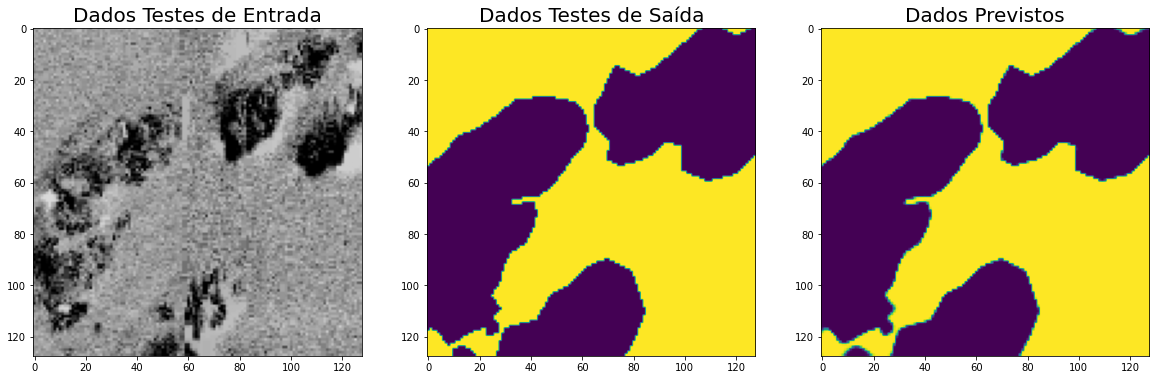

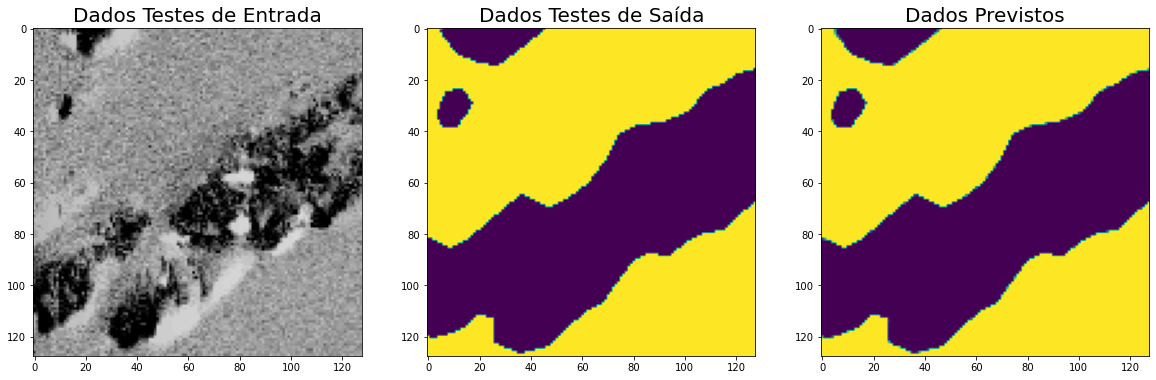

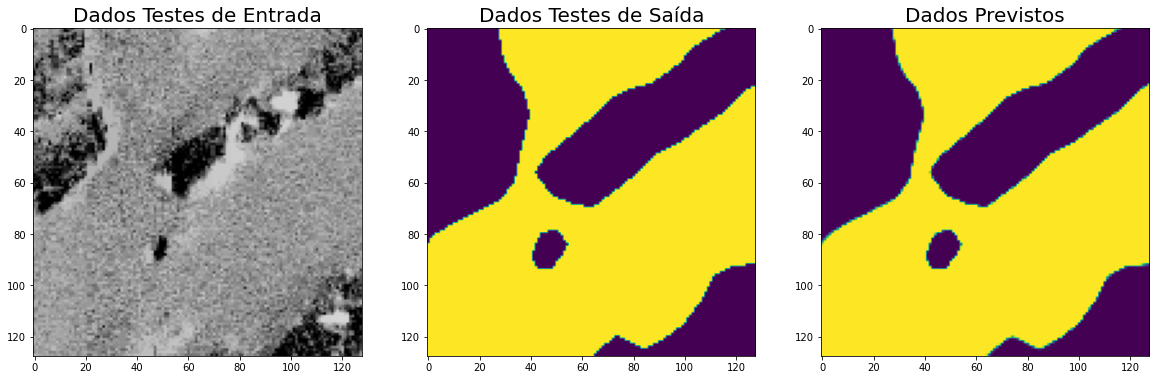

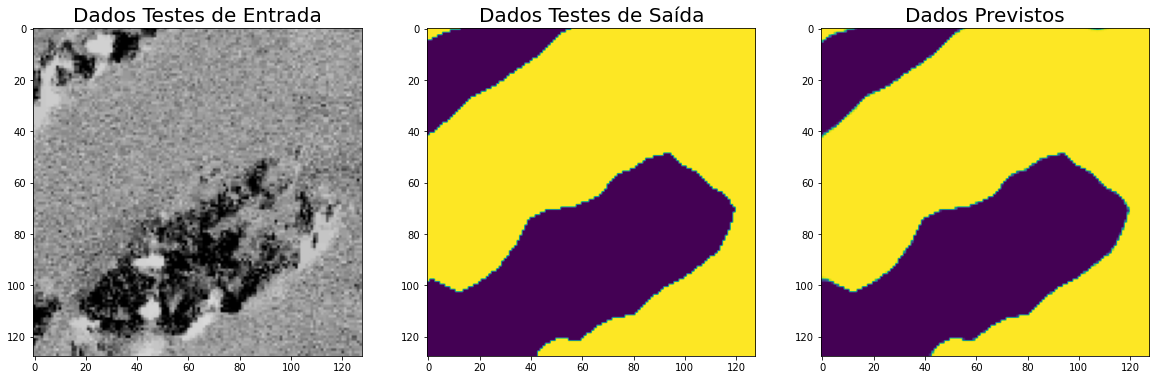

In [61]:
for i in range(20,25):
        plt.figure(figsize=(20,20))
        plt.subplot(1,3,1)
        plt.title("Dados Testes de Entrada",fontsize=20)
        plt.imshow(x_test[i])
        plt.subplot(1,3,2)
        plt.title("Dados Testes de Saída",fontsize=20)             
        plt.imshow(y_test[i])
        plt.subplot(1,3,3)
        plt.title("Dados Previstos",fontsize=20)
        plt.imshow(previsao_1[i])          
        plt.show()

# Modelo U-Net 2

In [62]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size =(kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [63]:
def get_unet(input_img,n_filters = 16, dropout = 0.5, batchnorm = True):
    c1 = conv2d_block(input_img,n_filters=n_filters,kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D(2,2)(c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    modelo_2 = Model(inputs=[input_img], outputs=[outputs])
    return modelo_2

In [64]:
input_img = Input((128, 128, 3))
modelo_2 = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

modelo_2.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
modelo_2.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [65]:
earlystopper = EarlyStopping(patience=2, monitor="val_loss", verbose=1)
checkpointer = ModelCheckpoint("model-SONAR-REV=I.h5", save_best_only=True)
Results_2 = modelo_2.fit(x_train, y_train,validation_data = (x_val,y_val), epochs=10,
                         callbacks=[earlystopper, checkpointer],verbose=1)

Epoch 1/10
113/113 [==============================] - 281s 2s/step - loss: 0.2478 - accuracy: 0.9134 - val_loss: 0.6022 - val_accuracy: 0.7271
Epoch 2/10
113/113 [==============================] - 279s 2s/step - loss: 0.1110 - accuracy: 0.9652 - val_loss: 0.4764 - val_accuracy: 0.8142
Epoch 3/10
113/113 [==============================] - 277s 2s/step - loss: 0.0756 - accuracy: 0.9744 - val_loss: 0.2045 - val_accuracy: 0.9280
Epoch 4/10
113/113 [==============================] - 278s 2s/step - loss: 0.0588 - accuracy: 0.9789 - val_loss: 0.0834 - val_accuracy: 0.9692
Epoch 5/10
113/113 [==============================] - 276s 2s/step - loss: 0.0507 - accuracy: 0.9811 - val_loss: 0.0546 - val_accuracy: 0.9783
Epoch 6/10
113/113 [==============================] - 276s 2s/step - loss: 0.0454 - accuracy: 0.9826 - val_loss: 0.0510 - val_accuracy: 0.9794
Epoch 7/10
113/113 [==============================] - 288s 3s/step - loss: 0.0406 - accuracy: 0.9842 - val_loss: 0.0438 - val_accuracy: 0.9823

In [66]:
# melhores acurácias e loss dos dados de treinamento e validação

print('melhor acurácia treino:', np.max(Results_2.history["accuracy"]))
print('melhor acurácia validação:', np.max(Results_2.history["val_accuracy"]))
print('melhor loss treino:', np.min(Results_2.history["loss"]))
print('melhor loss validação:', np.min(Results_2.history["val_loss"]))

melhor acurácia treino: 0.9865597486495972
melhor acurácia validação: 0.9865679740905762
melhor loss treino: 0.0335303358733654
melhor loss validação: 0.03238528221845627


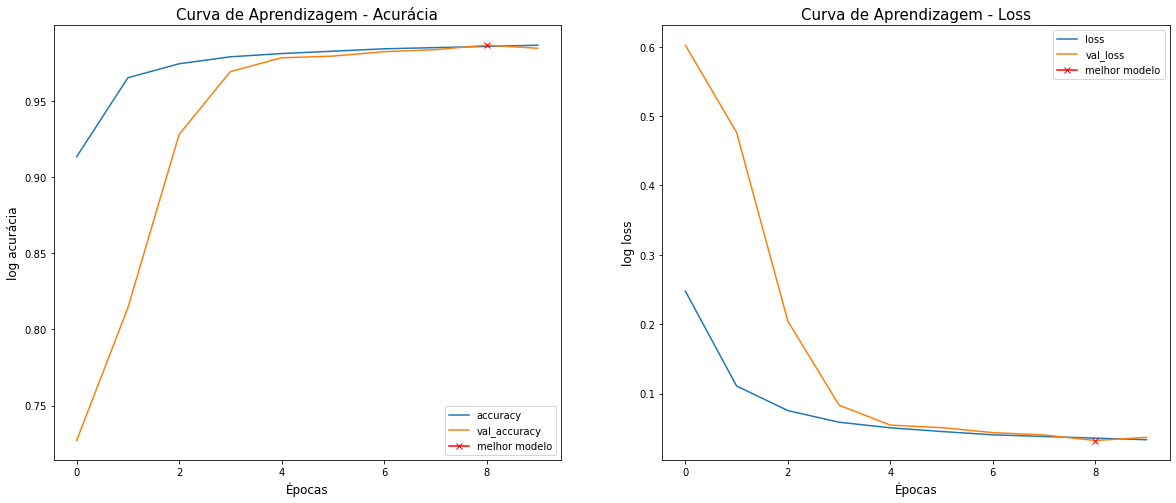

In [67]:
# performance do modelo graficamente

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title("Curva de Aprendizagem - Acurácia", fontsize=15)
plt.plot(Results_2.history["accuracy"], label="accuracy")
plt.plot(Results_2.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(Results_2.history["val_accuracy"]), np.max(Results_2.history["val_accuracy"]), marker="x", color="r", label="melhor modelo")
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("log acurácia",fontsize=12)
plt.legend()
plt.subplot(1,2,2)
plt.title("Curva de Aprendizagem - Loss", fontsize=15)
plt.plot(Results_2.history["loss"], label="loss")
plt.plot(Results_2.history["val_loss"], label="val_loss")
plt.plot( np.argmin(Results_2.history["val_loss"]), np.min(Results_2.history["val_loss"]), marker="x", color="r", label="melhor modelo")
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("log loss",fontsize=12)
plt.legend()

In [68]:
# carregamento do melhor modelo

modelo_2.load_weights("model-SONAR-REV=I.h5")

In [69]:
# avaliação da acurácia e loss nos dados de teste

test_loss, test_acc = modelo_2.evaluate(x_test,  y_test, verbose=2)

print('\nAcurácia dos dados de teste:', test_acc)

38/38 - 26s - loss: 0.0321 - accuracy: 0.9867

Acurácia dos dados de teste: 0.9867152571678162


In [70]:
# previsões

previsao_2 = modelo_2.predict(x_test)

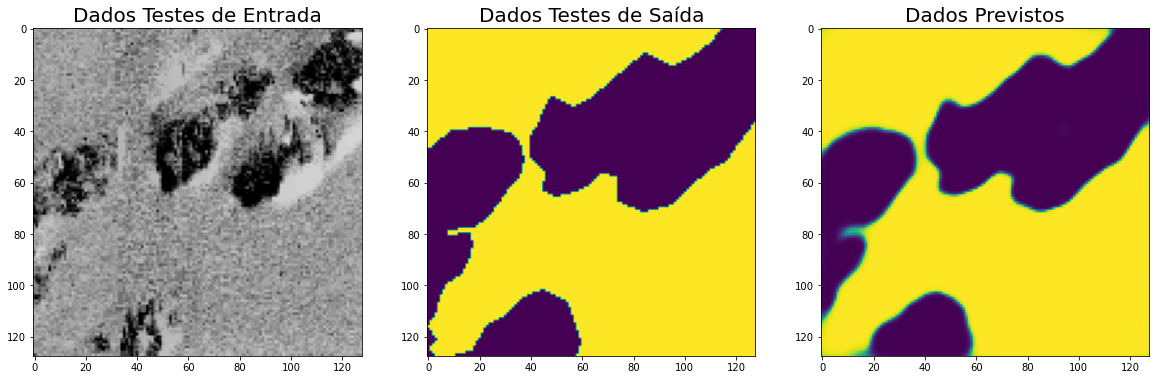

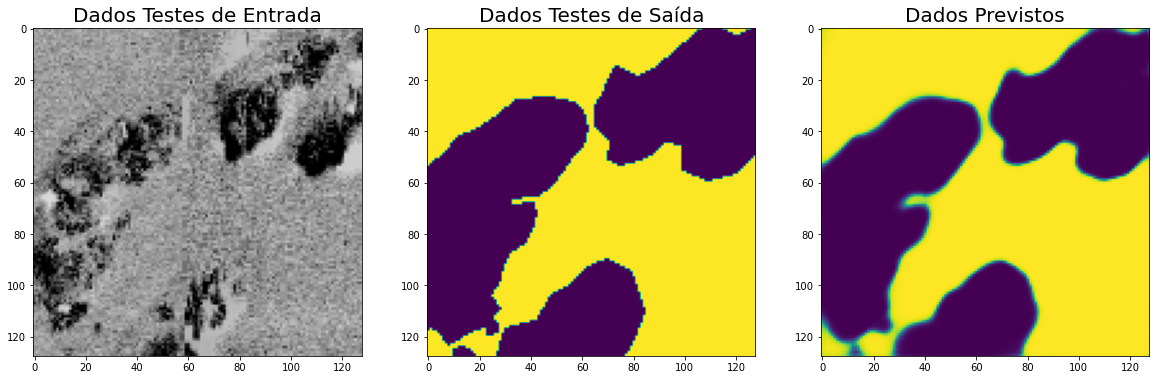

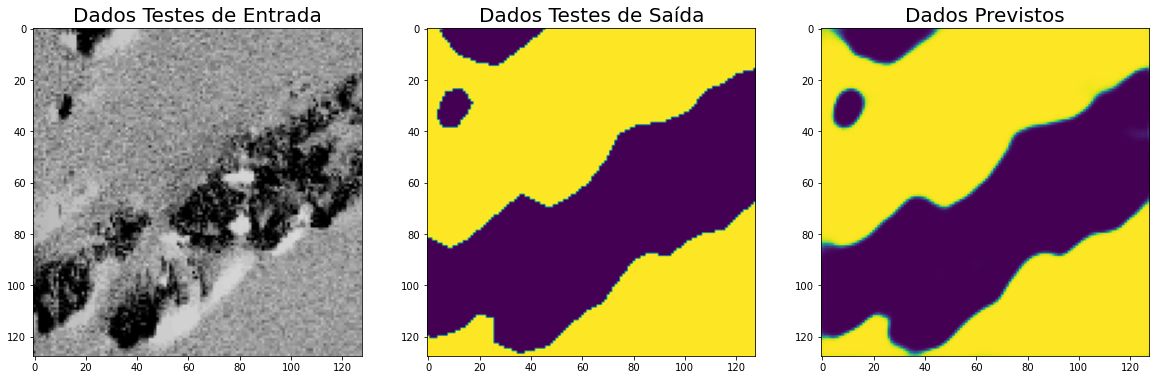

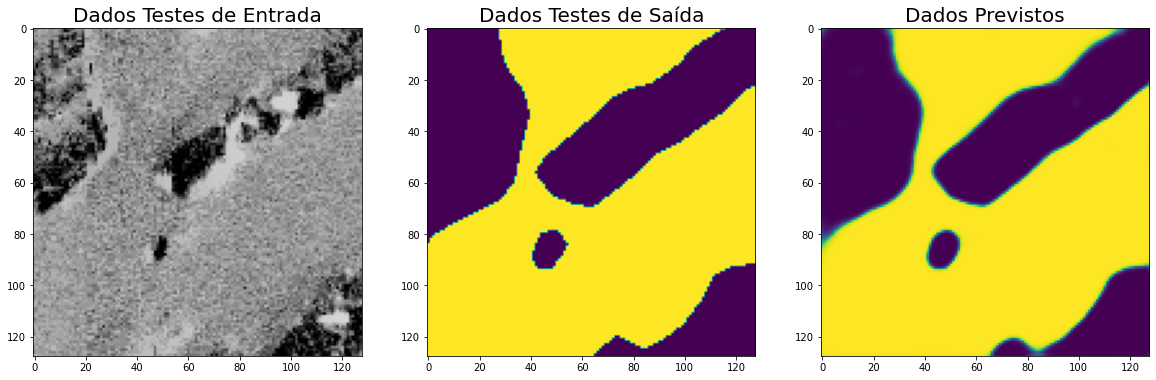

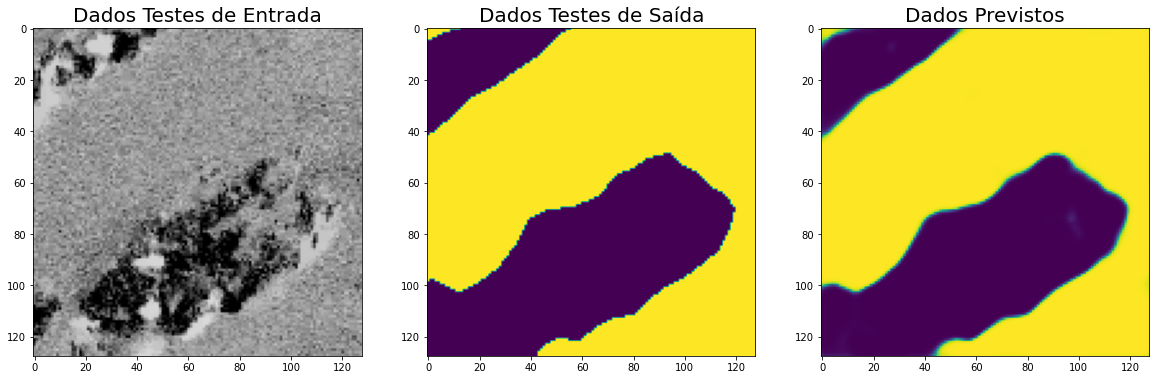

In [71]:
for i in range(20,25):
        plt.figure(figsize=(20,20))
        plt.subplot(1,3,1)
        plt.title("Dados Testes de Entrada",fontsize=20)
        plt.imshow(x_test[i])
        plt.subplot(1,3,2)
        plt.title("Dados Testes de Saída",fontsize=20)             
        plt.imshow(y_test[i])
        plt.subplot(1,3,3)
        plt.title("Dados Previstos",fontsize=20)
        plt.imshow(previsao_2[i])          
        plt.show()

# Modelo U-Net 3

In [75]:
inputs = Input((128, 128, 3))


c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

modelo_3 = Model(inputs=[inputs], outputs=[outputs])
modelo_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_3.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 128, 128, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 128, 128, 16) 0           conv2d_95[0][0]                  
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 128, 128, 16) 2320        dropout_17[0][0]                 
______________________________________________________________________________________

In [76]:
# Fit model
earlystopper = EarlyStopping(patience=2, verbose=1)
checkpointer = ModelCheckpoint("model-SONAR-REV=J.h5", verbose=1, save_best_only=True)


Results_3 = modelo_3.fit(x_train, y_train, validation_data = (x_val,y_val), epochs=20, batch_size=16, 
                         callbacks=[earlystopper, checkpointer],verbose=1)

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9257
Epoch 00001: val_loss improved from inf to 0.27249, saving model to model-SONAR-REV=J.h5
225/225 [==============================] - 322s 1s/step - loss: 0.1705 - accuracy: 0.9257 - val_loss: 0.2725 - val_accuracy: 0.9203
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9814
Epoch 00002: val_loss improved from 0.27249 to 0.09535, saving model to model-SONAR-REV=J.h5
225/225 [==============================] - 312s 1s/step - loss: 0.0438 - accuracy: 0.9814 - val_loss: 0.0953 - val_accuracy: 0.9681
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9876
Epoch 00003: val_loss improved from 0.09535 to 0.04682, saving model to model-SONAR-REV=J.h5
225/225 [==============================] - 307s 1s/step - loss: 0.0290 - accuracy: 0.9876 - val_loss: 0.0468 - val_accuracy: 0.9809
Epoch 4/20
225/225 [=====================

In [77]:
# melhores acurácias e loss dos dados de treinamento e validação

print('melhor acurácia treino:', np.max(Results_3.history["accuracy"]))
print('melhor acurácia validação:', np.max(Results_3.history["val_accuracy"]))
print('melhor loss treino:', np.min(Results_3.history["loss"]))
print('melhor loss validação:', np.min(Results_3.history["val_loss"]))

melhor acurácia treino: 0.9970982074737549
melhor acurácia validação: 0.9975191354751587
melhor loss treino: 0.007007678505033255
melhor loss validação: 0.005816167686134577


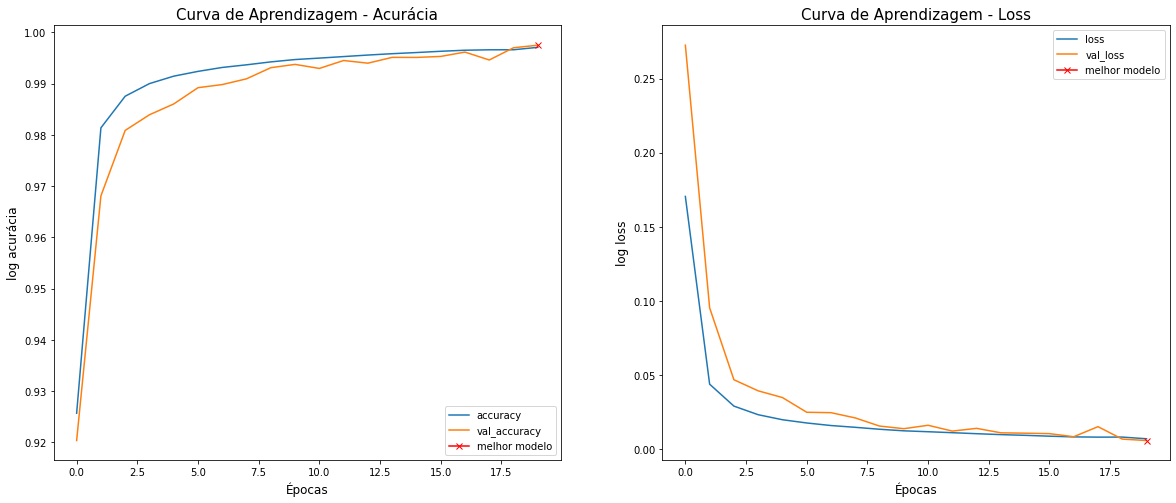

In [78]:
# performance do modelo graficamente

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.title("Curva de Aprendizagem - Acurácia", fontsize=15)
plt.plot(Results_3.history["accuracy"], label="accuracy")
plt.plot(Results_3.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(Results_3.history["val_accuracy"]), np.max(Results_3.history["val_accuracy"]), marker="x", color="r", label="melhor modelo")
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("log acurácia",fontsize=12)
plt.legend()
plt.subplot(1,2,2)
plt.title("Curva de Aprendizagem - Loss", fontsize=15)
plt.plot(Results_3.history["loss"], label="loss")
plt.plot(Results_3.history["val_loss"], label="val_loss")
plt.plot( np.argmin(Results_3.history["val_loss"]), np.min(Results_3.history["val_loss"]), marker="x", color="r", label="melhor modelo")
plt.xlabel("Épocas",fontsize=12)
plt.ylabel("log loss",fontsize=12)
plt.legend()

In [79]:
# carregamento do melhor modelo

modelo_3.load_weights("model-SONAR-REV=J.h5")

In [80]:
# avaliação da acurácia e loss nos dados de teste

test_loss, test_acc = modelo_3.evaluate(x_test,  y_test, verbose=2)

print('\nAcurácia dos dados de teste:', test_acc)

38/38 - 30s - loss: 0.0058 - accuracy: 0.9975

Acurácia dos dados de teste: 0.9974907040596008


In [81]:
# previsões

previsao_3 = modelo_3.predict(x_test)

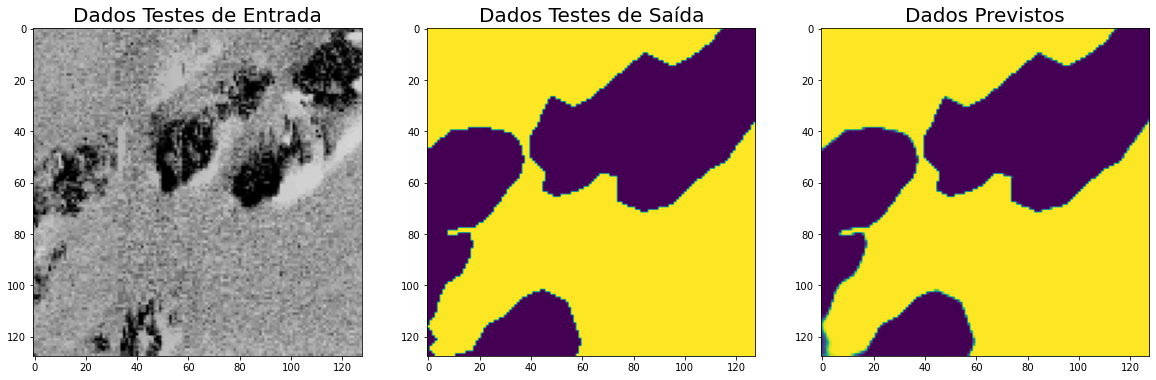

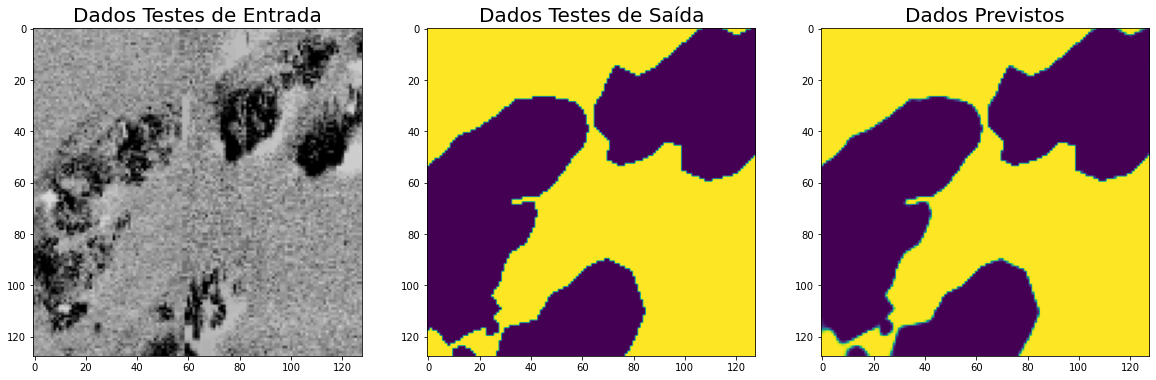

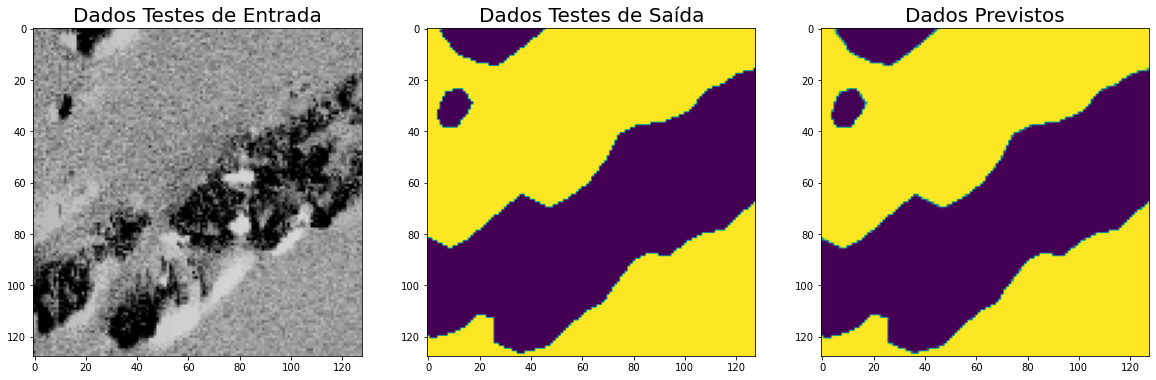

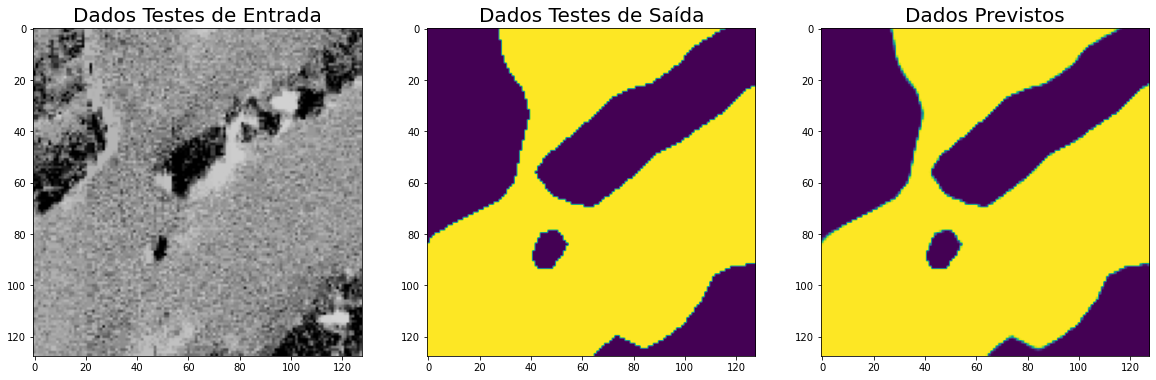

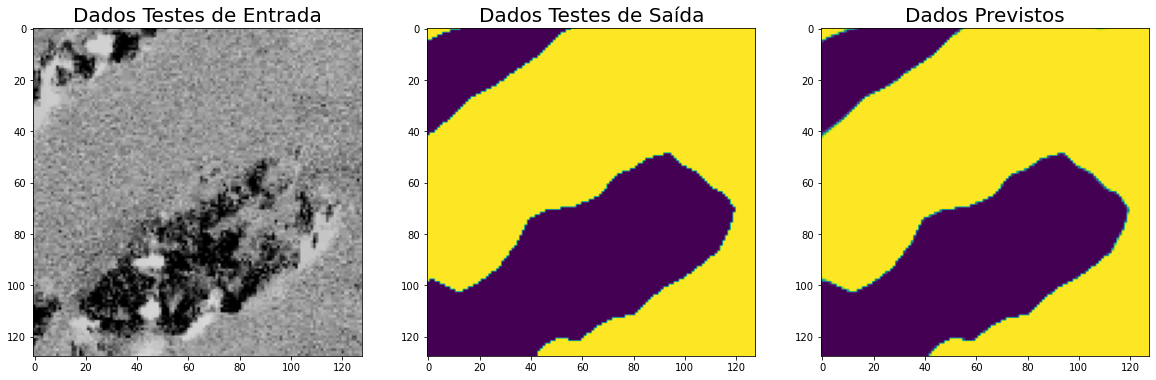

In [82]:
for i in range(20,25):
        plt.figure(figsize=(20,20))
        plt.subplot(1,3,1)
        plt.title("Dados Testes de Entrada",fontsize=20)
        plt.imshow(x_test[i])
        plt.subplot(1,3,2)
        plt.title("Dados Testes de Saída",fontsize=20)             
        plt.imshow(y_test[i])
        plt.subplot(1,3,3)
        plt.title("Dados Previstos",fontsize=20)
        plt.imshow(previsao_3[i])          
        plt.show()